# A fast Gumbel-max sampler

Among random samplers for high-dimensional categorical distributions the Gumbel-max trick is the most stable in the sense that, fixing randomness, changes to its input parameters lead to the fewest changes to its samples. This property is desirable in systems leveraging approximate floating point numerics, where fully determinism is too costly but deterministic results are desired. However the Gumbel-max trick is much more expensive than other simpler samplers, e.g. whereas a naive inverse-cdf sampler costs only a single random number generator call, a naive Gumbel-max trick requires `num_categories`-many random number generator calls.

This notebook implements a Gumbel-max sampler that is stable but consumes much less randomness, I believe something like $O(\sqrt N)$-many random number generator calls in expectation. In fact it turns out to be end-to-end competitive with other samplers that input logits vectors, due to its reduced number of calls to special functions `log` and `exp`. This is of practical importance in e.g. LLM serving.

In [1]:
import contextlib
import heapq
from collections import Counter
from timeit import default_timer
from typing import Callable

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

np.random.seed(20240824)

In [2]:
counter = Counter()

@contextlib.contextmanager
def counting():
    global counte
    counter.clear()
    yield
    for key, value in sorted(counter.items()):
        print(f"{key: >9}: {value: >5}")

In [3]:
def categorical_sample(logits: np.ndarray, seed: int | None = None) -> int:
    if seed is not None:
        np.random.seed(seed)
    counter["exp"] += len(logits)
    counter["uniform"] += 1
    probs = np.exp(logits - np.max(logits))
    probs /= np.sum(probs)
    return np.random.choice(len(logits), p=probs)

In [4]:
def gumbel_max_naive(logits: np.ndarray, seed: int | None = None) -> int:
    if seed is not None:
        np.random.seed(seed)
    counter["uniform"] += 1
    counter["log"] += 2 * len(logits)
    return int(np.argmax(logits + np.random.gumbel(size=logits.shape)))

In [5]:
LOG_2 = np.log(2)

def gumbel_icdf(u):
    counter["log"] += 2
    u = np.clip(u, np.finfo(type(u)).tiny, 1. - np.finfo(type(u)).eps)
    return -np.log(-np.log(u))

def gumbel_cdf(x):
    counter["exp"] += 2
    return np.exp(-np.exp(-x))

def uniform():
    counter["uniform"] += 1
    return np.random.uniform()

def bernoulli():
    counter["bernoulli"] += 1
    return np.random.uniform() < 0.5

In [6]:
def gumbel_max_stack(logits: np.ndarray) -> int:
    N = len(logits)
    if N & (N - 1) != 0:
        raise NotImplementedError('N must be a power of 2')
    # Consider a binary tree of N leaves, with internal nodes at addresses.
    # [empty, root, root.left, root.right, root.left.left, root.left.right, ...]
    tree_height = N.bit_length() - 1
    root_address = 1

    # Pass 1: Compute recursive maxima bottom-up.
    maxima = np.full(2 * N, np.nan, dtype=logits.dtype)
    maxima[N: 2 * N] = logits
    size = N
    while size > 1:
        x = maxima[size: 2 * size: 2]
        y = maxima[size + 1: 2 * size: 2]
        maxima[size // 2: size] = np.maximum(x, y)
        size //= 2

    # Pass 2: Sample recursively top-down.
    gumbels = np.full(2 * N, np.nan, dtype=logits.dtype)
    i_best = N
    x_best = -np.inf
    # Sample root g ~ Gumbel(log(2) * tree_height).
    root_mean = LOG_2 * tree_height
    gumbels[root_address] = gumbel_icdf(uniform()) + root_mean
    ub_root = maxima[root_address] + gumbels[root_address]
    stack = [(ub_root, root_address, root_mean)]
    while stack:
        ub, address, mean = stack.pop()
        if ub <= x_best:
            continue
        if address >= N:  # Leaf.
            i_best = address - N
            x_best = ub
            continue
        # Internal node.
        left = 2 * address
        right = 2 * address + 1
        # Sample children, transforming independent random variables
        #   g_parent ~ Gumbel(log(2) * (height + 1))
        #   u_new ~ Uniform(0, 1)
        # into iid random variables
        #   g_left, g_right ~ Gumbel(log(2) * height)
        upper, lower = (left, right) if bernoulli() else (right, left)
        g_upper = gumbels[upper] = gumbels[address]
        mean -= LOG_2
        if 0:  # In terms of uniform random variables.
            u_upper = gumbel_cdf(g_upper - mean)
            u_lower = u_upper * uniform()  # truncated sample
            g_lower = gumbels[lower] = gumbel_icdf(u_lower) + mean
        else:  # In terms of exponential random variables.
            e_upper = np.exp(mean - g_upper)
            e_lower = e_upper - np.log(uniform())
            g_lower = gumbels[lower] = mean - np.log(e_lower)
            counter["log"] += 2
            counter["exp"] += 1
            counter.update(log=2, exp=1)
        assert g_lower <= g_upper
        # Recurse, conditional on upper bounds.
        ub_right = maxima[right] + gumbels[right]
        if ub_right > x_best:
            stack.append((ub_right, right, mean))
        ub_left = maxima[left] + gumbels[left]
        if ub_left > x_best:
            stack.append((ub_left, left, mean))

    assert i_best != N
    return i_best


In [7]:
def gumbel_max_pstack(logits: np.ndarray) -> int:
    N = len(logits)
    if N & (N - 1) != 0:
        raise NotImplementedError('N must be a power of 2')
    # Consider a binary tree of N leaves, with internal nodes at addresses.
    # [empty, root, root.left, root.right, root.left.left, root.left.right, ...]
    tree_height = N.bit_length() - 1
    root_address = 1

    # Pass 1: Compute recursive maxima bottom-up.
    maxima = np.full(2 * N, np.nan, dtype=logits.dtype)
    maxima[N: 2 * N] = logits
    size = N
    while size > 1:
        x = maxima[size: 2 * size: 2]
        y = maxima[size + 1: 2 * size: 2]
        maxima[size // 2: size] = np.maximum(x, y)
        size //= 2

    # Pass 2: Sample recursively top-down.
    gumbels = np.full(2 * N, np.nan, dtype=logits.dtype)
    i_best = N
    x_best = -np.inf
    # Sample root g ~ Gumbel(log(2) * tree_height).
    root_mean = LOG_2 * tree_height
    gumbels[root_address] = gumbel_icdf(uniform()) + root_mean
    ub_root = maxima[root_address] + gumbels[root_address]
    stack = [(ub_root, root_address, root_mean)]
    while stack:
        ub, address, mean = stack.pop()
        if ub <= x_best:
            continue
        if address >= N:  # Leaf.
            i_best = address - N
            x_best = ub
            continue
        # Internal node.
        left = 2 * address
        right = 2 * address + 1
        # Sample children, transforming independent random variables
        #   g_parent ~ Gumbel(log(2) * (height + 1))
        #   u_new ~ Uniform(0, 1)
        # into iid random variables
        #   g_left, g_right ~ Gumbel(log(2) * height)
        upper, lower = (left, right) if bernoulli() else (right, left)
        g_upper = gumbels[upper] = gumbels[address]
        mean -= LOG_2
        if 0:  # In terms of uniform random variables.
            u_upper = gumbel_cdf(g_upper - mean)
            u_lower = u_upper * uniform()  # truncated sample
            g_lower = gumbels[lower] = gumbel_icdf(u_lower) + mean
        else:  # In terms of exponential random variables.
            e_upper = np.exp(mean - g_upper)
            e_lower = e_upper - np.log(uniform())
            g_lower = gumbels[lower] = mean - np.log(e_lower)
            counter["log"] += 2
            counter["exp"] += 1
            counter.update(log=2, exp=1)
        assert g_lower <= g_upper
        # Recurse, conditional on upper bounds, prioritizing promising children.
        ub_left = maxima[left] + gumbels[left]
        ub_right = maxima[right] + gumbels[right]
        left_first = ub_left > ub_right
        first, ub_first = (left, ub_left) if left_first else (right, ub_right)
        second, ub_second = (right, ub_right) if left_first else (left, ub_left)
        if ub_second > x_best:
            stack.append((ub_second, second, mean))
        if ub_first > x_best:
            stack.append((ub_first, first, mean))

    assert i_best != N
    return i_best


In [8]:
def gumbel_max_heap(logits: np.ndarray, seed: int | None = None) -> int:
    N = len(logits)
    if N & (N - 1) != 0:
        raise NotImplementedError('N must be a power of 2')
    # Consider a binary tree of N leaves, with internal nodes at addresses.
    # [empty, root, root.left, root.right, root.left.left, root.left.right, ...]
    tree_height = N.bit_length() - 1
    root_address = 1

    # Pass 1: Compute recursive maxima bottom-up.
    maxima = np.full(2 * N, np.nan, dtype=logits.dtype)
    maxima[N: 2 * N] = logits
    size = N
    while size > 1:
        x = maxima[size: 2 * size: 2]
        y = maxima[size + 1: 2 * size: 2]
        maxima[size // 2: size] = np.maximum(x, y)
        size //= 2

    # Pass 2: Sample recursively top-down.
    if seed is not None:
        np.random.seed(seed + root_address)
    gumbels = np.full(2 * N, np.nan, dtype=logits.dtype)
    i_best = N
    x_best = -np.inf
    # Sample root g ~ Gumbel(log(2) * tree_height).
    root_mean = LOG_2 * tree_height
    gumbels[root_address] = gumbel_icdf(uniform()) + root_mean
    ub_root = maxima[root_address] + gumbels[root_address]
    heap = [(-ub_root, root_address, root_mean)]
    while heap:
        ub, address, mean = heapq.heappop(heap)
        ub = -ub
        if ub <= x_best:
            continue
        if address >= N:  # Leaf.
            i_best = address - N
            x_best = ub
            continue
        # Internal node.
        if seed is not None:
            np.random.seed(seed + address)
        left = 2 * address
        right = 2 * address + 1
        # Sample children, transforming independent random variables
        #   g_parent ~ Gumbel(log(2) * (height + 1))
        #   u_new ~ Uniform(0, 1)
        # into iid random variables
        #   g_left, g_right ~ Gumbel(log(2) * height)
        upper, lower = (left, right) if bernoulli() else (right, left)
        g_upper = gumbels[upper] = gumbels[address]
        mean -= LOG_2
        if 0:  # In terms of uniform random variables.
            u_upper = gumbel_cdf(g_upper - mean)
            u_lower = u_upper * uniform()  # truncated sample
            g_lower = gumbels[lower] = gumbel_icdf(u_lower) + mean
        else:  # In terms of exponential random variables.
            e_upper = np.exp(mean - g_upper)
            e_lower = e_upper - np.log(uniform())
            g_lower = gumbels[lower] = mean - np.log(e_lower)
            counter["log"] += 2
            counter["exp"] += 1
            counter.update(log=2, exp=1)
        assert g_lower <= g_upper
        # Recurse, conditional on upper bounds, prioritizing promising children.
        ub_left = maxima[left] + gumbels[left]
        ub_right = maxima[right] + gumbels[right]
        if ub_left > x_best:
            heapq.heappush(heap, (-ub_left, left, mean))
        if ub_right > x_best:
            heapq.heappush(heap, (-ub_right, right, mean))

    assert i_best != N
    return i_best


In [9]:
%%time
with counting():
    for _ in range(1000):
        logits = np.random.randn(1 << 15)
        gumbel_max_heap(logits)

bernoulli: 87670
      exp: 175340
      log: 352680
  uniform: 88670
CPU times: user 1.03 s, sys: 29.1 ms, total: 1.06 s
Wall time: 1.15 s


In [10]:
samplers = [
    categorical_sample,
    gumbel_max_naive,
    gumbel_max_stack,
    gumbel_max_pstack,
    gumbel_max_heap,
]

## Correctness test

In [11]:
def goodness_of_fit(logits: np.ndarray, counts: np.ndarray) -> float:
    probs = np.exp(logits - np.max(logits))
    probs /= np.sum(probs)
    # Use Pearson's chi-squared test.
    count = np.sum(counts)
    var = probs * (1 - probs) / count
    z = counts / count - probs
    chi2 = np.dot(z, z / var)
    p_value = 1 - scipy.stats.chi2.cdf(chi2, len(counts) - 1)
    return p_value

In [12]:
def test_gof(sampler, logits, n_samples=1000):
    counts = np.zeros_like(logits)
    for _ in range(n_samples):
        counts[sampler(logits)] += 1
    gof = goodness_of_fit(logits, counts)
    print(f"{sampler.__name__}: {gof:.3f}")
    assert gof > 0.01, f"{sampler.__name__} has bad goodness of fit"

In [13]:
%%time
logits = np.random.randn(16)
for sampler in samplers:
    test_gof(sampler, logits)


categorical_sample: 0.111
gumbel_max_naive: 0.195
gumbel_max_stack: 0.421
gumbel_max_pstack: 0.408
gumbel_max_heap: 0.260
CPU times: user 169 ms, sys: 13.7 ms, total: 183 ms
Wall time: 223 ms


## Asymptotic complexity

In [14]:
def count_ops(sampler, dim, n_samples=100) -> Counter[int]:
    counter.clear()
    start_time = default_timer()
    for _ in range(n_samples):
        logits = np.random.randn(dim)
        sampler(logits)
    counter["time"] = default_timer() - start_time
    counter["n_samples"] = n_samples
    return counter.copy()

In [15]:
%%time
dims = [2 ** i for i in range(1, 21)]
counts = {
    sampler.__name__: [count_ops(sampler, dim) for dim in dims]
    for sampler in samplers
}

CPU times: user 27 s, sys: 2.29 s, total: 29.3 s
Wall time: 29.7 s


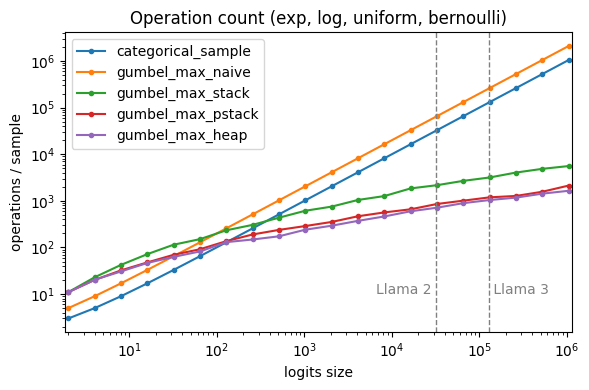

In [16]:
def plot_ops():
    plt.figure(figsize=(6, 4))
    for name, stats in counts.items():
        ops = []
        for stat in stats:
            stat = stat.copy()
            stat.pop("time")
            n_samples = stat.pop("n_samples")
            ops.append(sum(stat.values()) / n_samples)
        plt.plot(dims, ops, label=name, marker=".")
    plt.xlim(dims[0] / 1.1, dims[-1] * 1.1)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("logits size")
    plt.ylabel("operations / sample")
    plt.title("Operation count (exp, log, uniform, bernoulli)")
    plt.legend(loc="upper left")
    # Example llama sizes.
    plt.axvline(32000, color="gray", linestyle="--", lw=1)
    plt.text(32000, 1e1, "Llama 2 ", color="gray", ha="right")
    plt.axvline(128256, color="gray", linestyle="--", lw=1)
    plt.text(128256, 1e1, " Llama 3", color="gray", ha="left")
    plt.tight_layout()

plot_ops()

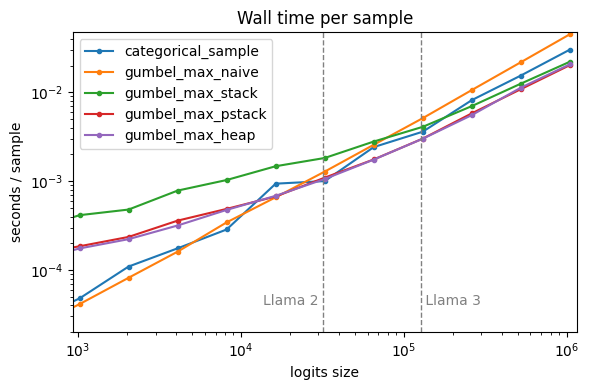

In [17]:
def plot_time():
    plt.figure(figsize=(6, 4))
    for name, stats in counts.items():
        times = [stat["time"] / stat["n_samples"] for stat in stats]
        plt.plot(dims, times, label=name, marker=".")
    plt.xlim(dims[9] / 1.1, dims[-1] * 1.1)
    plt.ylim(2e-5, None)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("logits size")
    plt.ylabel("seconds / sample")
    plt.title("Wall time per sample")
    plt.legend(loc="upper left")
    # Example llama sizes.
    plt.axvline(32000, color="gray", linestyle="--", lw=1)
    plt.text(32000, 4e-5, "Llama 2 ", color="gray", ha="right")
    plt.axvline(128256, color="gray", linestyle="--", lw=1)
    plt.text(128256, 4e-5, " Llama 3", color="gray", ha="left")
    plt.tight_layout()

plot_time()

## Stability

A desirable property of a random sampler is stability under parameter drift, so that sampled values are robust to small changes in parameters (e.g. numerical changes). We can measure this as the smallest parameter change size leading to a changed sample.

In [18]:
def measure_stability(gen: Callable[[np.ndarray, int], int], dim, n_samples=400, log_h_tol=0.05) -> float:
    # print(f"Measuring stability of {gen.__name__} with dim={dim}")
    mean_log_h = 0.0
    for seed in range(n_samples):
        np.random.seed(seed)
        x = np.random.randn(dim)
        dx = np.random.randn(dim)

        def is_stable(log_h: float) -> bool:
            h = np.exp(log_h)
            c1 = gen(x + h * dx, seed + 1)
            c2 = gen(x - h * dx, seed + 1)
            return c1 == c2
        min_log_h = -15
        max_log_h = 5
        assert is_stable(min_log_h), "unstable at min_log_h"
        assert not is_stable(max_log_h), "stable at max_log_h"
        # Bisection search for the threshold.
        while max_log_h - min_log_h > log_h_tol:
            log_h = (min_log_h + max_log_h) / 2
            if is_stable(log_h):
                min_log_h = log_h
            else:
                max_log_h = log_h
        log_h = (min_log_h + max_log_h) / 2
        mean_log_h += np.exp(log_h)

    mean_log_h /= n_samples
    return np.exp(mean_log_h)

In [19]:
%time
dims = [2 ** i for i in [2, 3, 4, 5, 6, 8, 10, 12, 14]]
stability = {
    sampler.__name__: [measure_stability(sampler, dim) for dim in dims]
    for sampler in [categorical_sample, gumbel_max_naive, gumbel_max_heap]
}

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 4.77 µs


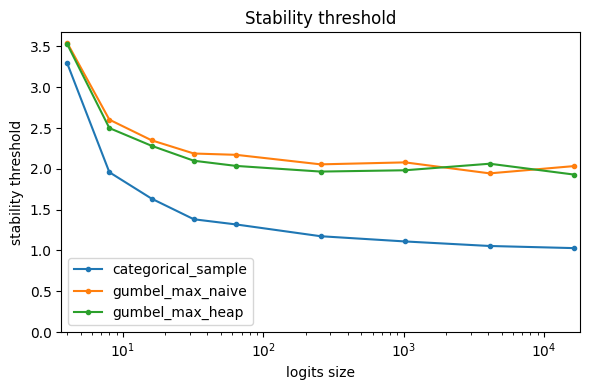

In [20]:
def plot_stability():
    plt.figure(figsize=(6, 4))
    for name, stats in stability.items():
        plt.plot(dims, stats, label=name, marker=".")
    plt.xlim(dims[0] / 1.1, dims[-1] * 1.1)
    plt.ylim(0, None)
    plt.xscale("log")
    plt.xlabel("logits size")
    plt.ylabel("stability threshold")
    plt.title("Stability threshold")
    plt.legend(loc="lower left")
    plt.tight_layout()

plot_stability()

## Related work

1. Iris A. M. Huijben, Wouter Kool, Max B. Paulus, Ruud J. G. van Sloun (2022) <br/>
   "A Review of the Gumbel-max Trick and its Extensions for Discrete Stochasticity
in Machine Learning" <br/>
   https://arxiv.org/abs/2110.01515
2. Yiyan Qi, Pinghui Wang, Yuanming Zhang, Junzhou Zhao, Guangjian Tian, Xiaohong Guan (2020) <br/>
   "Fast Generating A Large Number of Gumbel-Max Variables" <br/>
   https://arxiv.org/abs/2002.00413
3. Kirill Struminsky, Artyom Gadetsky, Denis Rakitin, Danil Karpushkin, Dmitry Vetrov (2021) <br/>
   "Leveraging Recursive Gumbel-Max Trick for Approximate Inference in Combinatorial Spaces" <br/>
   https://arxiv.org/abs/2110.15072
4. Feras Saad, Cameron Freer, Martin Rinard, Vikash Mansinghka (2020) <br/>
   "The Fast Loaded Dice Roller: A Near-Optimal Exact Sampler for Discrete Probability Distributions" <br/>
   https://arxiv.org/abs/2003.03830